# ⚙️ Pipeline de Preprocessing (Nettoyage & Feature Engineering)


## 1. Initialisation

In [2]:
# --- CELLULE 1 : INITIALISATION ---
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Chargement du dataset
df = pd.read_csv("../Data/data.csv", sep=';')

df_ml = df.copy()

print("Initialisation terminée. Copie créée.")

Initialisation terminée. Copie créée.


## 2. Feature Selection (Suppressions)

In [3]:
# --- CELLULE 2 : SUPPRESSION DES COLONNES (DROP) ---

cols_to_drop = [
    'Nacionality',             # 98% de Portugais (Bruit)
    'Application mode',         # Redondant avec l'Âge (Simplification)
    'Previous qualification',   # Redondant/Complexe (Simplification)
    'Mother\'s qualification',  # Encodage trompeur
    'Father\'s qualification', 
    'Mother\'s occupation',     # Trop de catégories
    'Father\'s occupation',
    'Educational special needs', # Trop rare (<1%)
    'International',
    'Curricular units 1st sem (without evaluations)', # Variance nulle
    'Curricular units 2nd sem (without evaluations)',
    'Curricular units 1st sem (credited)',
    'Curricular units 2nd sem (credited)'
]

df_ml = df_ml.drop(columns=cols_to_drop, errors='ignore')
print(f"Nettoyage terminé. Il reste {df_ml.shape[1]} colonnes.")

Nettoyage terminé. Il reste 24 colonnes.


## 3. Binning et Corrections

In [4]:
# --- CELLULE 3 : REGROUPEMENT ET CORRECTION ---

cols_to_bin = ['Course', 'Marital status']

for col in cols_to_bin:
    if col in df_ml.columns:
        counts = df_ml[col].value_counts()
        valid_cats = counts[counts >= 20].index
        # Les catégories rares deviennent 99
        df_ml[col] = df_ml[col].apply(lambda x: x if x in valid_cats else 99)
        print(f"   -> Colonne '{col}' nettoyée.")

if 'Application order' in df_ml.columns:
    df_ml['Application order'] = df_ml['Application order'].clip(lower=1, upper=6)
    print("   -> Colonne 'Application order' corrigée (0->1 et 9->6).")

print("Étape 3 terminée.")

   -> Colonne 'Course' nettoyée.
   -> Colonne 'Marital status' nettoyée.
   -> Colonne 'Application order' corrigée (0->1 et 9->6).
Étape 3 terminée.


# 4. Encodage (One-Hot & Target)

In [5]:
# --- CELLULE 4 : CIBLE & ENCODAGE ---

# 1. Cible Binaire : Dropout = 1, Reste = 0
df_ml['Target'] = df_ml['Target'].apply(lambda x: 1 if x == 'Dropout' else 0)

# 2. Encodage One-Hot CIBLÉ
cols_to_encode = ['Course', 'Marital status']

for col in cols_to_encode:
    if col in df_ml.columns:
        df_ml[col] = df_ml[col].astype(str)

df_encoded = pd.get_dummies(df_ml, columns=cols_to_encode, drop_first=True)

print(f"Encodage terminé. Dimensions actuelles : {df_encoded.shape}")

Encodage terminé. Dimensions actuelles : (4424, 42)


## 4 Calcul du custom score

In [6]:
# --- CELLULE 5 : CUSTOM SCORE 
import numpy as np

# Initialisation du customScore
df_encoded['customScore'] = 0

# Normalisation simple pour les colonnes utilisées
df_encoded['Units1_norm'] = df_encoded['Curricular units 1st sem (approved)'] / \
                            df_encoded['Curricular units 1st sem (approved)'].max()

df_encoded['Units2_norm'] = df_encoded['Curricular units 2nd sem (approved)'] / \
                            df_encoded['Curricular units 2nd sem (approved)'].max()

if 'Tuition fees up to date' in df_encoded.columns:
    df_encoded['Tuition_norm'] = 1 - df_encoded['Tuition fees up to date']
else:
    df_encoded['Tuition_norm'] = 0

# Calcul pondéré du customScore
df_encoded['customScore'] = 0.4*df_encoded['Tuition_norm'] + \
                            0.3*(1 - df_encoded['Units1_norm']) + \
                            0.3*(1 - df_encoded['Units2_norm'])

df_encoded.drop(['Units1_norm','Units2_norm','Tuition_norm'], axis=1, inplace=True)

print("customScore calculé et ajouté au dataframe.")
df_encoded[['customScore','Target']].head()

customScore calculé et ajouté au dataframe.


,customScore,Target
0,0.600000,1
1,0.840769,0
2,1.000000,1
3,0.455769,0
4,0.452308,0


In [7]:
## 5. Split (Train/Test) et Standardisation

In [8]:
# --- CELLULE 6 : SPLIT & SCALING ---

# 1. Séparation
X = df_encoded.drop('Target', axis=1)
y = df_encoded['Target']

# 2. Split (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Scaling (Uniquement sur les vrais chiffres continus)
scaler = StandardScaler()


cols_numeric_real = [
    'Admission grade', 
    'Age at enrollment', 
    'Unemployment rate', 
    'Inflation rate', 
    'GDP',
    'Curricular units 1st sem (evaluations)', 
    'Curricular units 1st sem (approved)', 
    'Curricular units 1st sem (grade)',
    'Curricular units 2nd sem (evaluations)', 
    'Curricular units 2nd sem (approved)', 
    'Curricular units 2nd sem (grade)'
]

cols_to_scale = [c for c in cols_numeric_real if c in X_train.columns]

# Application
X_train_final = X_train.copy()
X_test_final = X_test.copy()

X_train_final[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test_final[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

print("\n🚀 TOUT EST PRÊT !")
print(f"Final Train Shape : {X_train_final.shape}")
print(f"Nombre de colonnes : {X_train_final.shape[1]}")


🚀 TOUT EST PRÊT !
Final Train Shape : (3539, 42)
Nombre de colonnes : 42


## 6 ANALYSE PCA (Pour la visualisation et l'interprétation)


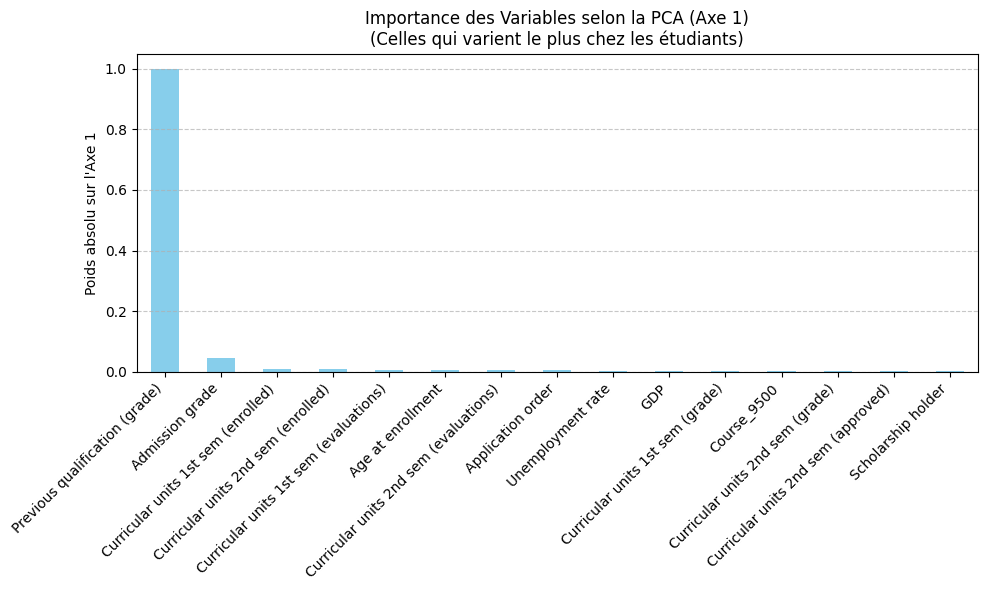

/home/michou/.local/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/michou/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


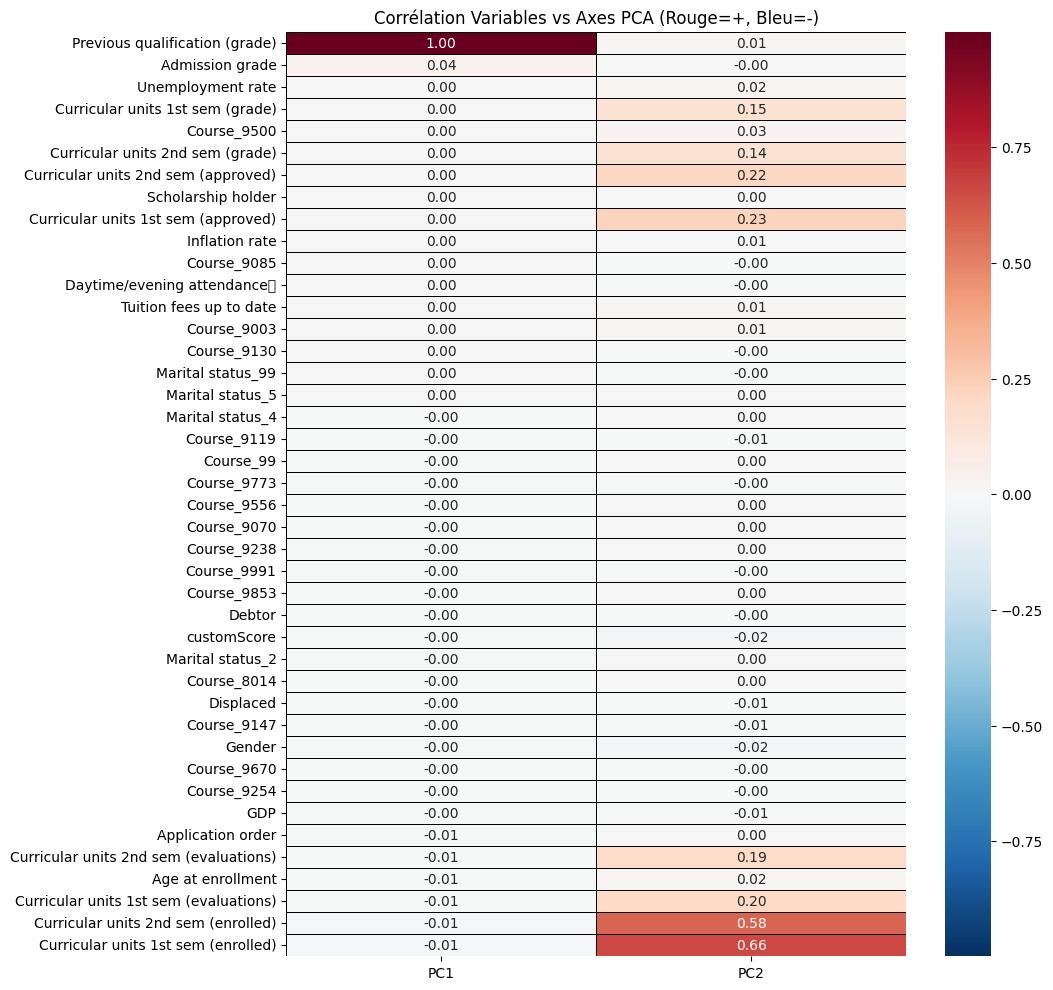

In [14]:

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# 1. On lance la PCA sur nos données Scalées (X_train_final)
# On regarde les 2 premiers axes (PC1 et PC2) qui résument le plus d'infos
pca = PCA(n_components=2)
pca.fit(X_train_final)

# 2. On récupère le poids de chaque variable (Loadings)
loadings = pca.components_.T
df_loadings = pd.DataFrame(loadings, columns=['PC1', 'PC2'], index=X_train_final.columns)

# 3. VISUALISATION 1 : Le "Top 10" des variables qui créent la différence (PC1)
plt.figure(figsize=(10, 6))
df_loadings['PC1'].abs().sort_values(ascending=False).head(15).plot(kind='bar', color='skyblue')
plt.title("Importance des Variables selon la PCA (Axe 1)\n(Celles qui varient le plus chez les étudiants)")
plt.ylabel("Poids absolu sur l'Axe 1")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# 1. On récupère le maximum absolu pour centrer l'échelle
limit = df_loadings.abs().max().max()

plt.figure(figsize=(10, 12))

sns.heatmap(
    df_loadings.sort_values(by='PC1', ascending=False), 
    annot=True, 
    fmt=".2f",          # On affiche 2 chiffres après la virgule
    cmap="RdBu_r",      # Palette Rouge (Haut) / Bleu (Bas)
    center=0,           # Le 0 sera BLANC
    vmin=-limit,        # Force le bleu foncé au minimum
    vmax=limit,         # Force le rouge foncé au maximum
    linewidths=0.5,     # Petites lignes pour séparer les cases
    linecolor='black'
)

plt.title("Corrélation Variables vs Axes PCA (Rouge=+, Bleu=-)")
plt.show()

In [10]:
# --- CELLULE 7 : AJOUT DU CUSTOM SCORE AUX FEATURES FINALES ---


X_train_final['customScore'] = df_encoded.loc[X_train_final.index, 'customScore']
X_test_final['customScore']  = df_encoded.loc[X_test_final.index, 'customScore']

print("customScore ajouté aux features finales")
print(f"Nouvelle dimension X_train_final : {X_train_final.shape}")
print(f"Nouvelle dimension X_test_final  : {X_test_final.shape}")


customScore ajouté aux features finales
Nouvelle dimension X_train_final : (3539, 42)
Nouvelle dimension X_test_final  : (885, 42)


## 7 Sauvegarde du dataset prétraité complet

In [11]:
# --- CELLULE 8 : CIBLE & ENCODAGE (fin de la cellule) ---

# Sauvegarde du dataset prétraité complet
df_encoded.to_csv("../Data/final.csv", index=False)
print("final.csv créé dans data")


final.csv créé dans data
